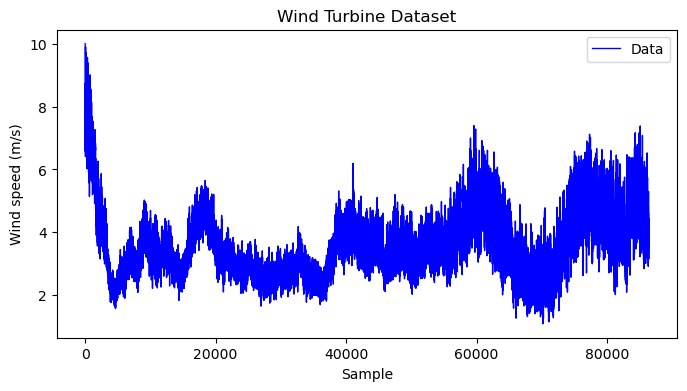

In [1]:
import numpy as np
import cvxpy as cp
import pandas as pd
from scipy.io import netcdf
import math
import kagglehub
import os
from GraphUtils import *
from StateObserver import *
from ReferenceConverter import *
from FeedbackController import *
from TorqueController import *

pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 100) 

MU = 2.0
SIGMA = 0.5

path = 'WindSpeed.csv'
df = pd.read_csv(path)  
v = df.iloc[:,0].values + 1e-16
v[0]=10
PlotSingle(y=v,w=8,yname=r'Wind speed (m/s)', xname='Sample', title='Wind Turbine Dataset',pltly=False)

In [2]:
params = {
    "Bdt": 755.49,
    "Kdt": 2.7*1e9,
    "Jg": 55*1e6,
    "Jr": 55*1e6,
    "rho": 1.225,
    "Ar": math.pi * (57.5**2),
    "Rr":  57.5,
    "Cp_Max": 0.486,
    "Lambda_opt": 7.6,
    "Dmax": 1000,
    "Vmax": 5,
    "Vmin": 0.2
}


In [8]:
Tcntrl = TorqueController(**params)
rep = 1
PD, PG = [], []
print(' X:',Tcntrl.X.T)
print('++++++++++++++++++++++++++++++++++++++++++')
    
for i in range(len(v[:1])):

    for j in range(rep):
        Tcntrl.update(v[i],uk=0,dt=1/rep, **params)
        print('dX:',Tcntrl.dX.T)
        print(' X:',Tcntrl.X.T)
        
    print('------------------------------------------')
    PD.append(Tcntrl.PD)
    PG.append(Tcntrl.PG)


 X: [[1.e-10 1.e-10 1.e-10]]
++++++++++++++++++++++++++++++++++++++++++
dX: [[-4.90909091e-09  4.90909091e-09  0.00000000e+00]]
 X: [[-4.80909091e-09  5.00909091e-09  1.00000000e-10]]
------------------------------------------


In [4]:
Tcntrl = TorqueController(**params)
rep = 1000
PD, PG = [], []
for i in range(len(v[:2])):
    for j in range(rep):
        print('j:',j,'----------------------')
        Tcntrl.update(v[i],uk=0,dt=1/rep, **params)
        print('ini:',Tcntrl.sttsB.T)
        #print('fin:',Tcntrl.sttsA.T)
        print('tau_r:',Tcntrl.tau_r,'tau_g:',Tcntrl.tau_g)
        print('Dot:',(1/rep)*Tcntrl.dstts.T)
    print('------------------------------------------')
    PD.append(Tcntrl.PD)
    PG.append(Tcntrl.PG)

j: 0 ----------------------


AttributeError: 'TorqueController' object has no attribute 'sttsB'

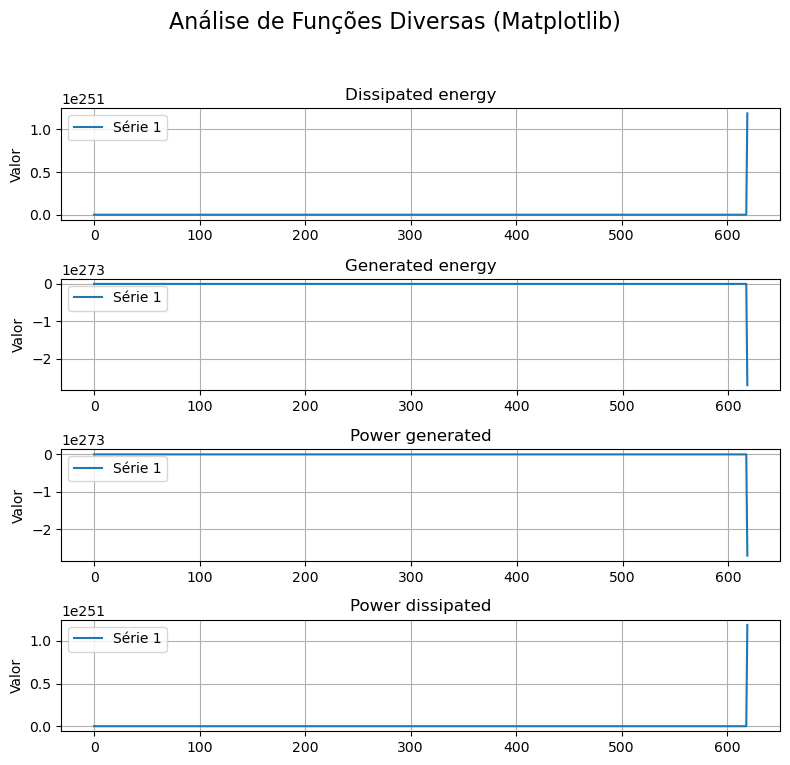

In [ ]:
EG_ = {
    'y_arrays': [Tcntrl.EG_],
    'x_arrays': None,
    'title': 'Generated energy',
    'xname': None,
    'yname': 'Valor',
    'legend_labels': None
}
ED_ = {
    'y_arrays': [Tcntrl.ED_],
    'x_arrays': None,
    'title': 'Dissipated energy',
    'xname': None,
    'yname': 'Valor',
    'legend_labels': None
}
PG_ = {
    'y_arrays': [Tcntrl.PG_],
    'x_arrays': None,
    'title': 'Power generated',
    'xname': None,
    'yname': 'Valor',
    'legend_labels': None
}
PD_ = {
    'y_arrays': [Tcntrl.PD_],
    'x_arrays': None,
    'title': 'Power dissipated',
    'xname': None,
    'yname': 'Valor',
    'legend_labels': None
}
all_plots = [ED_,EG_,PG_,PD_,]
MultiPlot(all_plots, rows=4, cols=1, pltly=False, main_title='Análise de Funções Diversas (Matplotlib)', fig_size=(8,8))


In [ ]:
i = 0
TorqueController_ = TorqueController(**params)
StateObserver_ = StateObserver(TS=0.001, **params)
ReferenceConverter_ = ReferenceConverter(RUL_ref=50530)
FeedbackController_ = FeedbackController(**params)
StateObserver_.solve_lmi_gain()
FeedbackController_.solve_lqr_gain()
lambda_star = None

In [ ]:
print(abcd)
ED_k = TorqueController_.update(v[i],lambda_star = lambda_star,dt=0.001, **params)

D_hat, beta_hat = StateObserver_.update(y_k=ED_k)

beta_ref = ReferenceConverter_.update(D_hat)

print('lambda_star:',lambda_star,'ED_k:',ED_k,'D_hat:',D_hat, 'beta_hat:',beta_hat, 'beta_ref:',beta_ref, 'lambda_star:', lambda_star)

lambda_star = FeedbackController_.update(beta_hat, beta_ref, dt=0.001)

i = i + 1

NameError: name 'abcd' is not defined

In [ ]:
ED, EG, K_mppt, D, B_ref,B_k = [np.array([]) for i in range(6)]
TorqueController_ = TorqueController(**params)
StateObserver_ = StateObserver(TS=0.001, **params)
ReferenceConverter_ = ReferenceConverter(RUL_ref=50530)
FeedbackController_ = FeedbackController(**params)
StateObserver_.solve_lmi_gain()
FeedbackController_.solve_lqr_gain()
lambda_star = None

for V in v:
    ED_k = TorqueController_.update(V,lambda_star = lambda_star,dt=0.001, **params)
    D_hat, beta_hat = StateObserver_.update(y_k=ED_k)
    beta_ref = ReferenceConverter_.update(D_hat)
    lambda_star = FeedbackController_.update(beta_hat, beta_ref, dt=0.001)
    print(FeedbackController_.lmbd_star)
    ED = np.append(ED,ED_k)
    D = np.append(D,D_hat)
    B_ref = np.append(B_ref,beta_ref)
    B_k = np.append(B_k,beta_hat)
    EG = np.append(EG,TorqueController_.EG)
    K_mppt = np.append(K_mppt,TorqueController_.K_mppt)

[7.60003698]
[7.60013083]
[7.60031224]
[7.60062845]
[7.60115234]
[7.60199621]
[7.60333321]
[7.60543022]
[7.60869867]
[7.61377276]
[7.62163008]
[7.63377755]
[7.65253797]
[7.68149169]
[7.72615746]
[7.7950417]
[7.90125593]
[8.06500968]
[8.31745295]
[8.70659863]
[9.30645109]
[10.23107618]
[11.65628792]
[13.8530749]
[17.23912134]
[22.45821838]
[30.50266308]
[42.90191609]
[62.01338578]
[91.47062318]
[136.87413943]
[206.85618491]
[314.72192786]
[480.97905593]
[737.23673276]
[1132.2151858]
[1741.00847808]
[2679.36151759]
[4125.67567309]
[6354.92674053]
[9790.94380039]
[15086.98830928]
[23249.95325671]
[35831.79533741]
[55224.59554224]
[85115.34557822]
[131186.92486847]
[202198.53904546]
[311651.03470158]
[480353.70280787]
[740380.57573753]
[1141168.39566617]
[1758915.61024662]
[2711069.34825303]
[4178654.66310582]
[6440691.31720604]
[9927241.48337612]
[15301173.88066096]
[23584189.47801974]
[36351068.98236426]
[56029072.76654118]
[86359415.64968055]
[1.33108553e+08]
[2.05164508e+08]
[3.1622668

c:\ControleRobustoArtigo\FeedbackController.py:127: RuntimeWarning:

overflow encountered in multiply



[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf]
[inf

c:\ControleRobustoArtigo\StateObserver.py:104: RuntimeWarning:

overflow encountered in add

c:\ControleRobustoArtigo\FeedbackController.py:127: RuntimeWarning:

invalid value encountered in subtract

c:\ControleRobustoArtigo\StateObserver.py:104: RuntimeWarning:

invalid value encountered in matmul

c:\ControleRobustoArtigo\StateObserver.py:104: RuntimeWarning:

invalid value encountered in matmul



[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan

c:\ControleRobustoArtigo\TorqueController.py:59: RuntimeWarning:

overflow encountered in multiply

c:\ControleRobustoArtigo\TorqueController.py:53: RuntimeWarning:

overflow encountered in square

c:\ControleRobustoArtigo\TorqueController.py:58: RuntimeWarning:

overflow encountered in square

c:\ControleRobustoArtigo\TorqueController.py:73: RuntimeWarning:

invalid value encountered in matmul

c:\ControleRobustoArtigo\TorqueController.py:73: RuntimeWarning:

invalid value encountered in matmul



[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan

KeyboardInterrupt: 

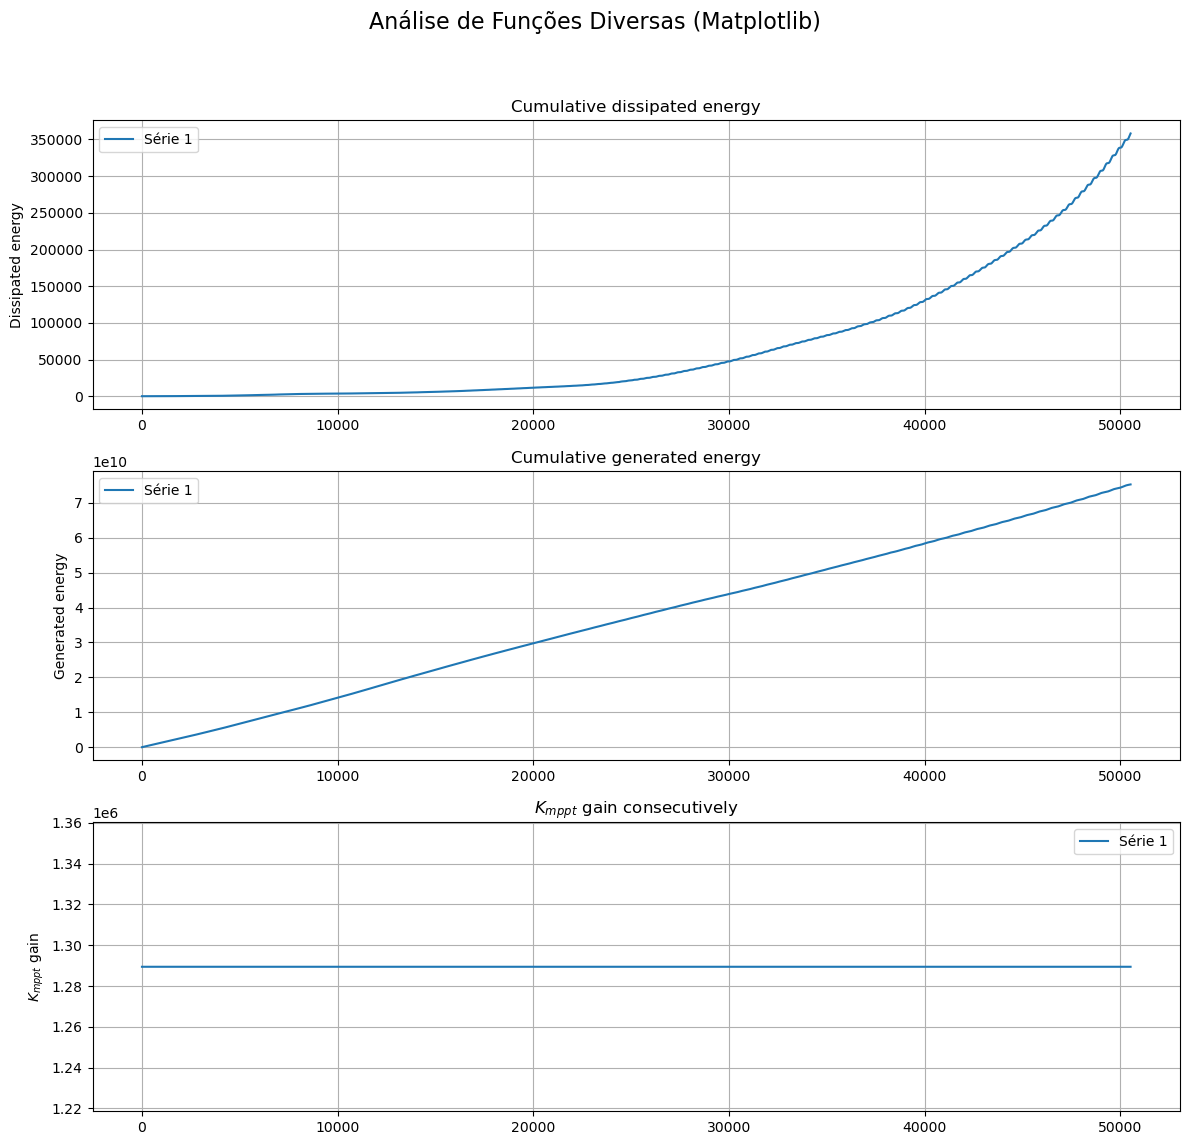

In [ ]:
EG_ = {
    'y_arrays': [EG],
    'x_arrays': None,
    'title': 'Cumulative generated energy',
    'xname': None,
    'yname': r'$E_{G}$',
    'legend_labels': None
}
ED_ = {
    'y_arrays': [ED],
    'x_arrays': None,
    'title': 'Cumulative dissipated energy',
    'xname': None,
    'yname': r'$E_{D}$',
    'legend_labels': None
}
K_ = {
    'y_arrays': [K_mppt],
    'x_arrays': None,
    'title': r'$K_{mppt}$ gain consecutively',
    'xname': None,
    'yname': r'$K_{mppt}$ gain',
    'legend_labels': None
}

D_ = {
    'y_arrays': [D],
    'x_arrays': None,
    'title': 'Degradation',
    'xname': None,
    'yname': r'$\hat{D}$',
    'legend_labels': None
}

B_ = {
    'y_arrays': [B_ref],
    'x_arrays': None,
    'title': 'Degradation rate',
    'xname': 'Sample',
    'yname': r'$\beta^{ref}$',
    'legend_labels': None
}
all_plots = [ED_,EG_,K_]
MultiPlot(all_plots, rows=3, cols=1, pltly=False, main_title='Análise de Funções Diversas (Matplotlib)', fig_size=(12,12))
